In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
sys.path.insert(0, "../")

In [48]:
from nohomers.notebook.widgets import expand2square, image_labeller_widget, display_df_images
from nohomers.ml.torch_datasets import SimpleVisionExample, SimpleVisionDataset, split_train_valid_test, pil_loader
from nohomers.ml.lightweight_gan_trainer import get_trainer, generate_images
from nohomers.ml.cleaner import (
    make_train_test_datasets, train_cleaner, make_network_input_from_images, load_cleaner, save_cleaner,
    VisionOnlyCleaner, VisionLatentCleaner
)
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import collections
import pandas as pd
import numpy as np
import torch
import torchvision
import pydash as py_
import copy
import sklearn.metrics
from tqdm.auto import tqdm
from uuid import uuid4
from PIL import Image
from pathlib import Path
import json
import copy
import shutil
from multiprocessing.pool import ThreadPool
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

[autoreload of nohomers.ml.cleaner failed: Traceback (most recent call last):
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: scores_for_images() requires a code object with 0 free vars, not 2
]


In [3]:
base_folder = Path("/mnt/evo/projects/nohomers/cleaners/simpsons_large_cleaned_nobackground_1024_augall03_sle_res64-40")
dataset_folder = base_folder / "images"

In [4]:
## If you want to remove
try:
    shutil.rmtree(base_folder)
except FileNotFoundError:
    pass
dataset_folder.mkdir(parents=True, exist_ok=True)

In [5]:
trainer = get_trainer(
    models_dir="/mnt/evo/projects/metapedia/tmp/stylegan2/models", 
    name="simpsons_large_cleaned_nobackground_1024_augall03_sle_res64",
    load_from=40,
)

loading from version 0.12.4


# Label Results

In [6]:
num_examples = 5000
per_batch = 100
dataset = []

def make_example(image):
    path = dataset_folder / f"{uuid4()}.png"
    image.image.save(path)
    return SimpleVisionExample(
        path=path,
        label=None,
        latent=image.latents.cpu(),
    )

with ThreadPool(32) as pool:
    for batch in tqdm(range(0, num_examples, per_batch)):
        images = generate_images(trainer, per_batch)
        dataset.extend(pool.imap(make_example, images))

In [7]:
dataset_by_path = {e.path: e for e in dataset}
labels = {}

In [20]:
to_label = py_.sample_size([e for e in dataset_by_path.keys() if e not in labels], 100)
image_labeller_widget(to_label, labels, ["N/A", "Good", "Bad"], image_size=(250, 250))

In [22]:
labeled_dataset = []
for path, label in labels.items():
    if label not in ("Good", "Bad"):
        continue
        
    dataset_item = dataset_by_path[path]
    new_item = copy.deepcopy(dataset_item)
    new_item.label = 1 if label == "Good" else 0
    labeled_dataset.append(new_item)

with open(dataset_folder / "labels.json", "w") as f:
    json.dump([l.to_dict() for l in labeled_dataset], f)

In [ ]:
with open(dataset_folder / "labels.json", "r") as f:
    labeled_dataset = [SimpleVisionExample.from_dict(e) for e in json.load(f)]

# Create Training Dataset Objects

In [23]:
percent_positive = np.array([e.label for e in labeled_dataset]).mean()
print(f"Num labelled={len(labeled_dataset)}, Percent positive: {100 * percent_positive:.2f}%")

Num labelled=1083, Percent positive: 26.78%


In [24]:
train_dataset, test_dataset = make_train_test_datasets(labeled_dataset)

Dataset sizes train=860, valid=0, test=223


## Results
* VisionLatentCleaner:
** lr=0.001, l2_reg=0.0005, batch_size=50, epochs=20:  **0.873 AUC** (overfit)
** lr=0.001, l2_reg=0.05, batch_size=50, epochs=20:  **0.883 AUC** 
** lr=0.001, l2_reg=0.05, batch_size=200, epochs=20:  **0.857 AUC** 
** nofreeze, **0.84 AUC**
** lr=0.0005, l2_reg=0.05, batch_size=50, epochs=20:  **0.79 AUC** 
** lr=0.002, l2_reg=0.05, batch_size=50, epochs=20:  **0.881 AUC** 
** lr=0.001, l2_reg=0.2, batch_size=50, epochs=20:  **0.87 AUC** 
** lr=0.001, l2_reg=0.1, batch_size=32, epochs=20:  **0.85 AUC** 
* VisionCleaner
** lr=0.001, l2_reg=0.0005, batch_size=50, epochs=20:  **0.847 AUC**
** lr=0.0001, l2_reg=0.0005, batch_size=50, epochs=20:  **0.836AUC**

In [37]:
cleaner = VisionLatentCleaner(latent_dim=labeled_dataset[0].latent.size(-1), freeze_resnet=True).cuda()

train_cleaner(
    cleaner,
    train_dataset, 
    test_dataset, 
    batch_size=50, 
    num_epochs=20,
    device="cuda:0",
    lr=0.001, 
    l2_reg=0.05, 
    clip_norm=1.0,
    workers=32,
)


Epoch 0: train_loss=0.011, train_auc=0.686, eval_loss=0.012, eval_auc=0.809



Epoch 1: train_loss=0.009, train_auc=0.835, eval_loss=0.011, eval_auc=0.855



Epoch 2: train_loss=0.008, train_auc=0.875, eval_loss=0.011, eval_auc=0.868



Epoch 3: train_loss=0.007, train_auc=0.909, eval_loss=0.010, eval_auc=0.864



Epoch 4: train_loss=0.007, train_auc=0.916, eval_loss=0.011, eval_auc=0.875



Epoch 5: train_loss=0.006, train_auc=0.937, eval_loss=0.010, eval_auc=0.855



Epoch 6: train_loss=0.007, train_auc=0.919, eval_loss=0.012, eval_auc=0.876



Epoch 7: train_loss=0.006, train_auc=0.951, eval_loss=0.009, eval_auc=0.867



Epoch 8: train_loss=0.006, train_auc=0.930, eval_loss=0.010, eval_auc=0.829



Epoch 9: train_loss=0.007, train_auc=0.906, eval_loss=0.015, eval_auc=0.881



Epoch 10: train_loss=0.006, train_auc=0.946, eval_loss=0.010, eval_auc=0.875



Epoch 11: train_loss=0.006, train_auc=0.935, eval_loss=0.010, eval_auc=0.830



Epoch 12: train_loss=0.006, train_auc=0.926, eval_loss=0.013, eval_auc=0.877



Epoch 13: train_loss=0.005, train_auc=0.966, eval_loss=0.009, eval_auc=0.864



Epoch 14: train_loss=0.005, train_auc=0.947, eval_loss=0.009, eval_auc=0.855



Epoch 15: train_loss=0.006, train_auc=0.941, eval_loss=0.010, eval_auc=0.869



Epoch 16: train_loss=0.005, train_auc=0.948, eval_loss=0.010, eval_auc=0.837



Epoch 17: train_loss=0.007, train_auc=0.901, eval_loss=0.013, eval_auc=0.880



Epoch 18: train_loss=0.005, train_auc=0.958, eval_loss=0.010, eval_auc=0.872


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79c8ffa160>
Traceback (most recent call last):
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f79c8ffa160>
Traceback (most recent call last):
  File "/home/tdimson/anaconda3/envs/nohomers/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/

Epoch 19: train_loss=0.005, train_auc=0.952, eval_loss=0.011, eval_auc=0.830

Loading best eval auc 0.8814858490566038 from epoch 9


In [39]:
save_cleaner(cleaner, base_folder / "cleaner.pkl")

In [41]:
print(f"Latent dim: {labeled_dataset[0].latent.size(-1)}")

Latent dim: 256


In [51]:
cleaner = load_cleaner(base_folder / "cleaner.pkl", latent_dim=256)

# Precision Recall Curve

In [53]:
true = []
preds = []
with torch.no_grad():
    for item, latents, label in test_dataset:
        true.append(label)
        pred = cleaner(item.unsqueeze(0).cuda(), latents.unsqueeze(0).cuda())
        prob = torch.nn.Softmax(dim=1)(pred).squeeze()
        preds.append(prob[1].item())

In [54]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true=np.array(true, dtype=np.float), probas_pred=np.array(preds, dtype=np.float))

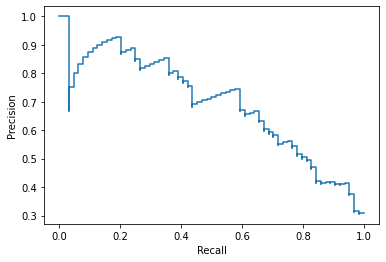

In [56]:
pr_display = sklearn.metrics.PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [57]:
{t: (p, r) for p, r, t in zip(precision, recall, thresholds)}

{0.016854779794812202: (0.30917874396135264, 1.0),
 0.017191600054502487: (0.3058252427184466, 0.984375),
 0.017383987084031105: (0.3073170731707317, 0.984375),
 0.01874343864619732: (0.3088235294117647, 0.984375),
 0.019175706431269646: (0.3103448275862069, 0.984375),
 0.019189737737178802: (0.3118811881188119, 0.984375),
 0.019607065245509148: (0.31343283582089554, 0.984375),
 0.01968502439558506: (0.315, 0.984375),
 0.019971543923020363: (0.3165829145728643, 0.984375),
 0.02006210945546627: (0.31313131313131315, 0.96875),
 0.020476343110203743: (0.3147208121827411, 0.96875),
 0.020897788926959038: (0.3163265306122449, 0.96875),
 0.021144872531294823: (0.31794871794871793, 0.96875),
 0.022016098722815514: (0.31958762886597936, 0.96875),
 0.02342231012880802: (0.32124352331606215, 0.96875),
 0.02436419203877449: (0.3229166666666667, 0.96875),
 0.025156473740935326: (0.32460732984293195, 0.96875),
 0.02525016851723194: (0.3263157894736842, 0.96875),
 0.025481505319476128: (0.3280423280

In [ ]:
thresholds

## Inspect Scores

In [61]:
labeled_paths = {e.path for e in labeled_dataset}
to_score = list(e for e in dataset_folder.glob("*.png") if e not in labeled_paths)
score_batch_size = 100
with ThreadPool(32) as pool:
    scores = []
    for batch_paths in tqdm(py_.chunk(to_score, score_batch_size), "Batches"):
        batch = make_network_input_from_images(list(pool.imap(lambda x: pil_loader(x), batch_paths))).cuda()
        latents = torch.vstack([dataset_by_path[p].latent for p in batch_paths]).cuda()
        batch_scores = cleaner.forward(batch, latents)
        probs = torch.nn.Softmax(dim=1)(batch_scores)
        scores.extend([p[1].item() for p in probs])

scored_df = pd.DataFrame(dict(
    path=[str(e) for e in to_score],
    score=scores,
))

In [62]:
scored_df["score"].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

0.10    0.017569
0.25    0.042128
0.50    0.098002
0.75    0.206885
0.90    0.411880
Name: score, dtype: float64

,path,score
3232,,0.550267
102,,0.889662
786,,0.596477
543,,0.551540
2096,,0.885962
3412,,0.541690
2771,,0.624562
2619,,0.592403
1403,,0.517663
838,,0.537338

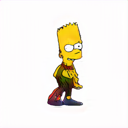
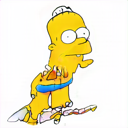
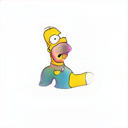
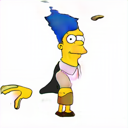
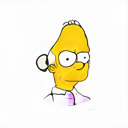
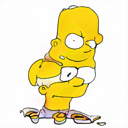
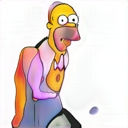
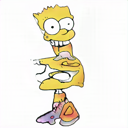
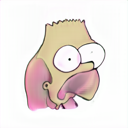
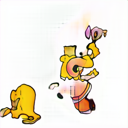
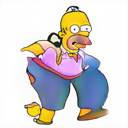
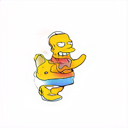
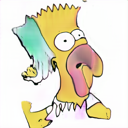
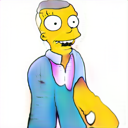
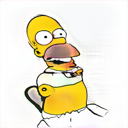
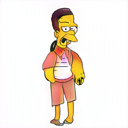
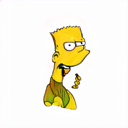
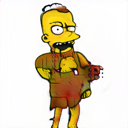
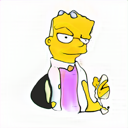
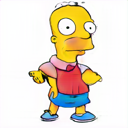
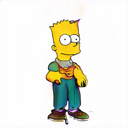
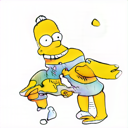
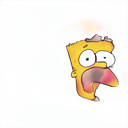
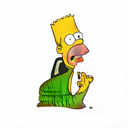
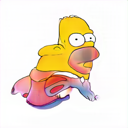
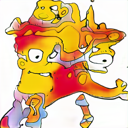
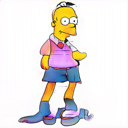
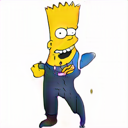
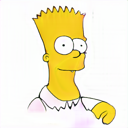
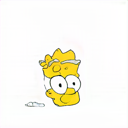
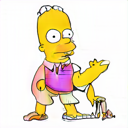
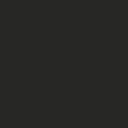
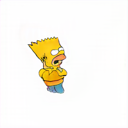
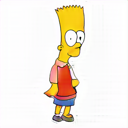
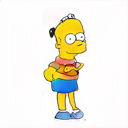
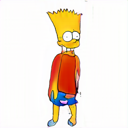
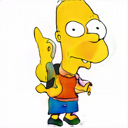
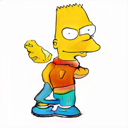
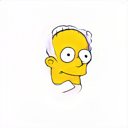
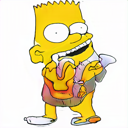
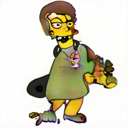
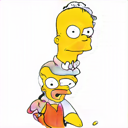
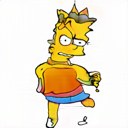
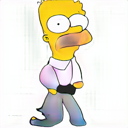
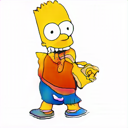
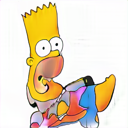
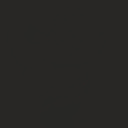
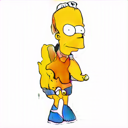
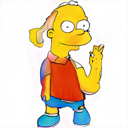
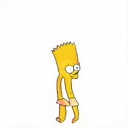

In [73]:
display_df_images(scored_df[scored_df["score"] > 0.5].sample(50)) #.sort_values("score", ascending=False))
# display_df_images(scored_df.sample(100).sort_values("score", ascending=False))